## Import Libraries

In [2]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, LeakyReLU
import numpy as np
from tensorflow.keras.initializers import TruncatedNormal
import tensorflow_datasets as tfds

## Setup GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(len(gpus))
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

1


## Load and Visualize Dataset

In [4]:
train_ds, test_ds = tfds.load('fashion_mnist', split=['train', 'test'])

In [5]:
data_iter = train_ds.as_numpy_iterator()

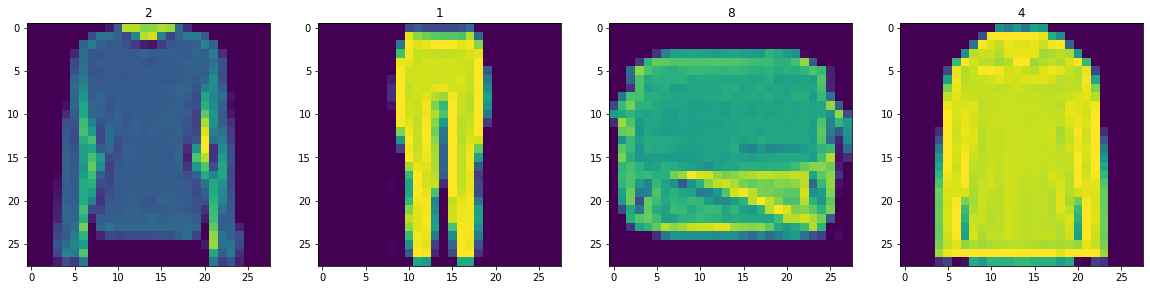

In [6]:
_, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample = data_iter.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

## Preprocess Images

In [7]:
BATCH_SIZE = 128

In [8]:
train_ds = train_ds.map(lambda data_: data_['image'])
test_ds = test_ds.map(lambda data_: data_['image'])

## Add Noise and Prepare Dataset

In [9]:
def map_image_with_noise(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    noise_factor = 0.35
    factor = noise_factor * tf.random.normal(shape=image.shape)
    image_noisy = image + factor
    image_noisy = tf.clip_by_value(image_noisy, 0.0, 1.0)
    return image_noisy, image

In [10]:
train_ds = train_ds.map(map_image_with_noise)
test_ds = test_ds.map(map_image_with_noise)
train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [11]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None))>

## Visualize Noisy Data

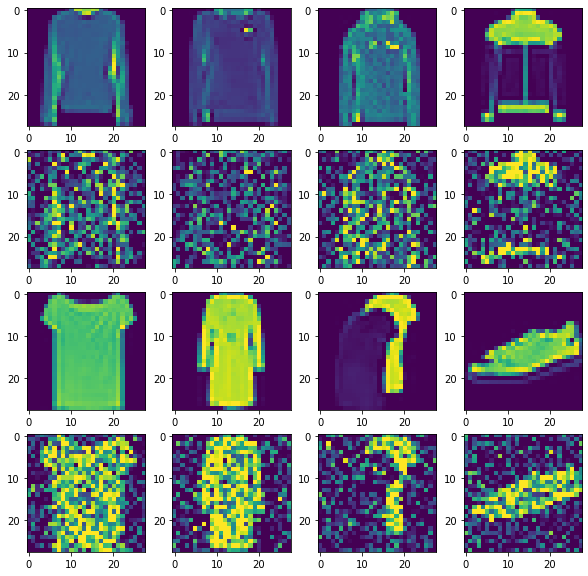

In [12]:
_, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
data_iter = train_ds.as_numpy_iterator()
for i in range(4):
    noisy_img, img = data_iter.next()
    ax[0][i].imshow(img[0])
    ax[1][i].imshow(noisy_img[0])
for i in range(4):
    noisy_img, img = data_iter.next()
    ax[2][i].imshow(img[0])
    ax[3][i].imshow(noisy_img[0])

## Build Encoder

In [21]:
input_layer = Input(shape=(28, 28, 1), name='InputLayerEnc')

conv_1 = Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02),
              name='Conv2D_Layer1')(input_layer)
act_1 = LeakyReLU(0.2, name='LeakyReLU_E1')(conv_1)

conv_2 = Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02),
              name='Conv2D_Layer2')(act_1)
act_2 = LeakyReLU(0.2, name='LeakyReLU_E2')(conv_2)

conv_3 = Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02),
              name='Conv2D_Layer3')(act_2)
act_3 = LeakyReLU(0.2, name='LeakyReLU_E3')(conv_3)

visualization_layer = Conv2D(filters=1, kernel_size=(5,5), strides=(1,1), padding='same',
                             kernel_initializer=TruncatedNormal(stddev=0.02),
                             name='EncoderVisLayer',
                             activation='sigmoid')(act_3)
encoder = tf.keras.Model(inputs = input_layer, outputs = visualization_layer, name='Encoder')
encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayerEnc (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D_Layer1 (Conv2D)      (None, 28, 28, 64)        1664      
                                                                 
 LeakyReLU_E1 (LeakyReLU)    (None, 28, 28, 64)        0         
                                                                 
 Conv2D_Layer2 (Conv2D)      (None, 14, 14, 128)       204928    
                                                                 
 LeakyReLU_E2 (LeakyReLU)    (None, 14, 14, 128)       0         
                                                                 
 Conv2D_Layer3 (Conv2D)      (None, 7, 7, 256)         819456    
                                                                 
 LeakyReLU_E3 (LeakyReLU)    (None, 7, 7, 256)         0   

#### Test Encoder

1/1 [==============================] - 13s 13s/step


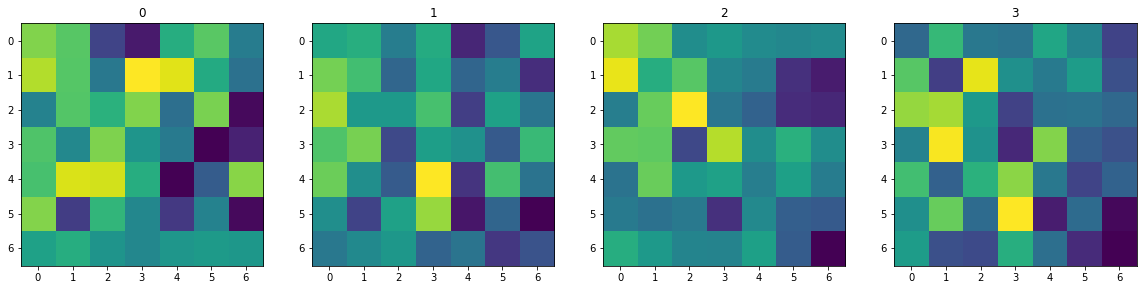

In [14]:
images = encoder.predict(np.random.randn(4,28,28,1))
_, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(images): 
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

## Build Decoder

In [15]:
conv_trans_1 = Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(2,2), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02),
              name='Conv2DTrans_Layer1')(act_3)
act_1D = LeakyReLU(0.2, name='LeakyReLU_D1')(conv_trans_1)

conv_trans_2 = Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02),
              name='Conv2DTrans_Layer2')(act_1D)
act_2D = LeakyReLU(0.2, name='LeakyReLU_D2')(conv_trans_2)

conv_trans_3 = Conv2DTranspose(filters=1, kernel_size=(5,5), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02),
              name='Conv2DTrans_Layer3')(act_2D)
act_3D = LeakyReLU(0.2, name='LeakyReLU_D3')(conv_trans_3)

## Build AutoEncoder

In [16]:
autoencoder = tf.keras.Model(inputs = input_layer, outputs = act_3D, name='AutoEncoder')
autoencoder.summary()      

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayerEnc (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D_Layer1 (Conv2D)      (None, 28, 28, 64)        1664      
                                                                 
 LeakyReLU_E1 (LeakyReLU)    (None, 28, 28, 64)        0         
                                                                 
 Conv2D_Layer2 (Conv2D)      (None, 14, 14, 128)       204928    
                                                                 
 LeakyReLU_E2 (LeakyReLU)    (None, 14, 14, 128)       0         
                                                                 
 Conv2D_Layer3 (Conv2D)      (None, 7, 7, 256)         819456    
                                                                 
 LeakyReLU_E3 (LeakyReLU)    (None, 7, 7, 256)         

#### Test Autoencoder

1/1 [==============================] - 2s 2s/step


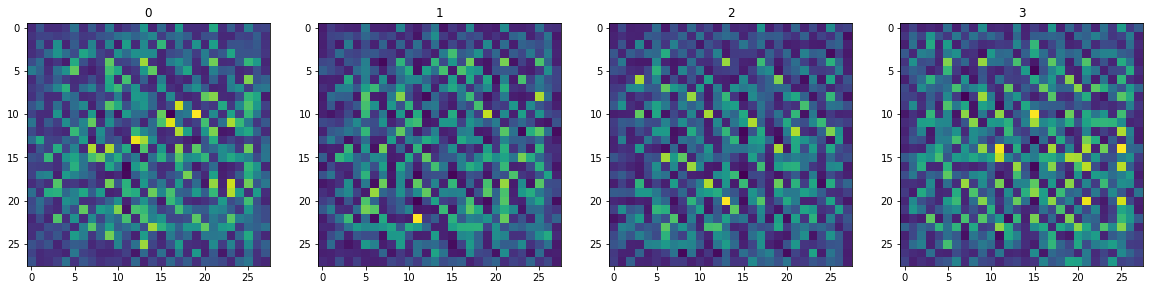

In [17]:
images = autoencoder.predict(np.random.randn(4,28,28,1))
_, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(images): 
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

## Initialize Model

In [18]:
from tensorflow.keras.optimizers import Adam

In [22]:
autoencoder.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='binary_crossentropy')

## Train Model

In [23]:
autoencoder.fit(train_ds, epochs = 5)

Epoch 1/5
469/469 [==============================] - 59s 120ms/step - loss: 0.3967
Epoch 2/5
469/469 [==============================] - 56s 119ms/step - loss: 0.3225
Epoch 3/5
469/469 [==============================] - 44s 93ms/step - loss: 0.3155
Epoch 4/5
469/469 [==============================] - 45s 96ms/step - loss: 0.3063
Epoch 5/5
469/469 [==============================] - 45s 96ms/step - loss: 0.3046


## Test Model on Random Test Images

4/4 [==============================] - 0s 15ms/step


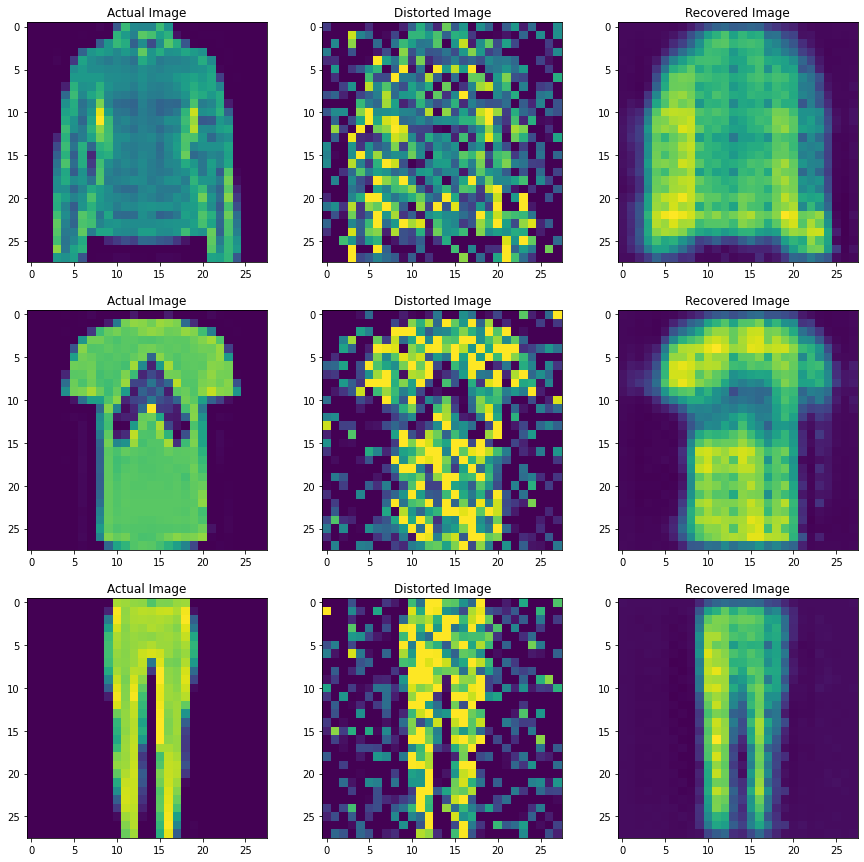

In [36]:
_, ax = plt.subplots(ncols=3, nrows=3, figsize=(15,15))
test_iter = test_ds.as_numpy_iterator()
for i in range(3):
    noisy_img, img = test_iter.next()
    pred_img = autoencoder.predict(noisy_img)
    ax[i][0].imshow(img[0])
    ax[i][0].title.set_text('Actual Image')
    ax[i][1].imshow(noisy_img[0])
    ax[i][1].title.set_text('Distorted Image')
    ax[i][2].imshow(pred_img[0])
    ax[i][2].title.set_text('Recovered Image')